# Community Detection in FriendFeed Network

This notebook focuses on detecting communities within the FriendFeed social network. We'll use the preprocessed datasets to build a graph and analyze community structures.

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import community
from community import community_louvain

%matplotlib inline
sns.set(style='whitegrid')

# Load preprocessed data
users = pd.read_parquet('processed_data/users_cleaned.parquet')
subs = pd.read_parquet('processed_data/subs_cleaned.parquet')
following = pd.read_parquet('processed_data/following_cleaned.parquet')
comments = pd.read_parquet('processed_data/comments_cleaned.parquet')
likes = pd.read_parquet('processed_data/likes_cleaned.parquet')

In [3]:
import pandas as pd
import pyarrow.parquet as pq

# Open the parquet file
parquet_file = pq.ParquetFile('processed_data/entries_cleaned.parquet')

# Get the actual number of row groups
num_row_groups = parquet_file.num_row_groups

# Initialize a list to collect chunks
entries_list = []

# Loop over each row group and process them one at a time
for i in range(num_row_groups):
    # Read the current row group
    entries_chunk = parquet_file.read_row_group(i).to_pandas()
    
    # Process the chunk if needed, then append it to the list
    entries_list.append(entries_chunk)

# Concatenate all chunks into a single DataFrame if needed
entries = pd.concat(entries_list, ignore_index=True)


In [5]:
print(entries['Timestamp'].max())
print(entries['Timestamp'].min())

2010-09-30 23:59:59
1970-01-01 00:00:01


In [4]:
# sizes of each dataframe
print('users:', users.shape)
print('subs:', subs.shape)
print('following:', following.shape)
print('comments:', comments.shape)
print('likes:', likes.shape)
print('entries:', entries.shape)


users: (645414, 4)
subs: (24761879, 2)
following: (18477145, 3)
comments: (2864942, 6)
likes: (442858, 3)
entries: (12450559, 5)


In [23]:
# length of unique users
print(users.columns)
print('unique users:', len(users['ID'].unique()))

print(subs.columns)
print('unique subs:', len(subs['FollowerID'].unique()))
print('unique subs:', len(subs['FollowedID'].unique()))

print(following.columns)
print('unique following:', len(following['FollowerID'].unique()))
print('unique following:', len(following['FollowedID'].unique()))

print(comments.columns)
print('unique comments:', len(comments['PostedBy'].unique()))

print(likes.columns)
print('unique likes:', len(likes['userID'].unique()))

print(entries.columns)
print('unique entries:', len(entries['PostedBy'].unique()))





Index(['ID', 'Type', 'Name', 'Description'], dtype='object')
unique users: 645414
Index(['FollowerID', 'FollowedID'], dtype='object')
unique subs: 525824
unique subs: 527108
Index(['FollowerID', 'FollowedID', 'Timestamp'], dtype='object')
unique following: 196436
unique following: 443552
Index(['PostID', 'EntryID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text'], dtype='object')
unique comments: 41692
Index(['userID', 'PostID', 'Timestamp'], dtype='object')
unique likes: 14533
Index(['PostID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text'], dtype='object')
unique entries: 256542


In [26]:
# Function to check consistency of user and post IDs across datasets
def check_user_post_consistency():
    # Define a set of valid user IDs and Post IDs
    valid_users = set(users['ID'])
    valid_posts = set(entries['PostID'])

    # Check each interaction dataset for user and post ID consistency
    def user_id_check(df, column_name, dataset_name):
        missing_users = df[~df[column_name].isin(valid_users)][column_name].unique()
        print(f"{dataset_name}: {len(missing_users)} user IDs not present in Users dataset.")
        return missing_users

    def post_id_check(df, column_name, dataset_name):
        missing_posts = df[~df[column_name].isin(valid_posts)][column_name].unique()
        print(f"{dataset_name}: {len(missing_posts)} post IDs not present in Entries dataset.")
        return missing_posts

    # Perform checks
    missing_likes_users = user_id_check(likes, 'userID', 'Likes')
    missing_comments_users = user_id_check(comments, 'PostedBy', 'Comments')
    missing_following_follower = user_id_check(following, 'FollowerID', 'Following (Follower)')
    missing_following_followed = user_id_check(following, 'FollowedID', 'Following (Followed)')
    missing_subs_follower = user_id_check(subs, 'FollowerID', 'Subscriptions (Follower)')
    missing_subs_followed = user_id_check(subs, 'FollowedID', 'Subscriptions (Followed)')
    
    missing_likes_posts = post_id_check(likes, 'PostID', 'Likes')
    missing_comments_posts = post_id_check(comments, 'EntryID', 'Comments')

    return missing_likes_users, missing_comments_users, missing_following_follower, missing_following_followed, missing_subs_follower, missing_subs_followed, missing_likes_posts, missing_comments_posts

# Run the check
missing_likes_users, missing_comments_users, missing_following_follower, missing_following_followed, missing_subs_follower, missing_subs_followed, missing_likes_posts, missing_comments_posts = check_user_post_consistency()

# print the results
print('missing_likes_users:', missing_likes_users)
print('missing_comments_users:', missing_comments_users)
print('missing_following_follower:', missing_following_follower)
print('missing_following_followed:', missing_following_followed)
print('missing_subs_follower:', missing_subs_follower)
print('missing_subs_followed:', missing_subs_followed)
print('missing_likes_posts:', missing_likes_posts)
print('missing_comments_posts:', missing_comments_posts)


Likes: 0 user IDs not present in Users dataset.
Comments: 0 user IDs not present in Users dataset.
Following (Follower): 0 user IDs not present in Users dataset.
Following (Followed): 0 user IDs not present in Users dataset.
Subscriptions (Follower): 0 user IDs not present in Users dataset.
Subscriptions (Followed): 0 user IDs not present in Users dataset.
Likes: 0 post IDs not present in Entries dataset.
Comments: 0 post IDs not present in Entries dataset.
missing_likes_users: []
missing_comments_users: []
missing_following_follower: []
missing_following_followed: []
missing_subs_follower: []
missing_subs_followed: []
missing_likes_posts: []
missing_comments_posts: []


## 2. Build the Network Graph

We'll create a directed graph where nodes represent users, and edges represent different types of interactions such as follows, likes, and comments.

In [4]:
# Initialize directed graph
G = nx.DiGraph()

# Add nodes for users
G.add_nodes_from(users['ID'])

# Add edges from the various types of interactions
# G.add_edges_from([(row['FollowerID'], row['FollowedID']) for idx, row in following.iterrows()])

# Display basic graph information
print(f"Graph has {G.number_of_nodes()}")
# print(f"Graph has {G.number_of_edges()} edges")

Graph has 645414


## 3. Analyze Network Structure

Let's examine the basic characteristics of the network, such as degree distributions.

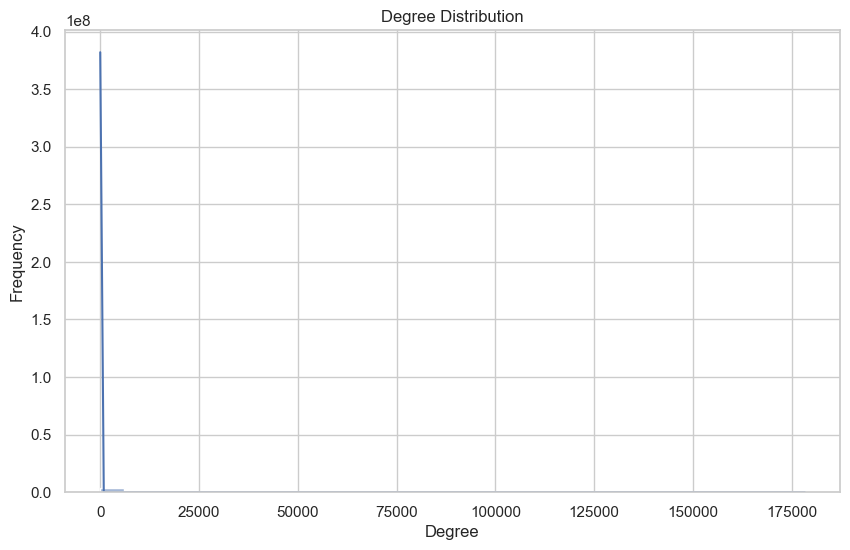

In [6]:
# Calculate degree distributions
degrees = dict(G.degree())
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Plot degree distribution
plt.figure(figsize=(10, 6))
sns.histplot(list(degrees.values()), bins=30, kde=True)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

## 4. Detect Communities Using the Louvain Method

The Louvain algorithm is a popular method for community detection in large networks. We'll use this method to detect communities and analyze them.

In [7]:
# Convert graph to undirected for community detection
G_undirected = G.to_undirected()

# Apply Louvain method for community detection
partition = community_louvain.best_partition(G_undirected)
communities = set(partition.values())
num_communities = len(communities)

print(f"Number of communities detected: {num_communities}")

# Add community information as node attribute
nx.set_node_attributes(G, partition, 'community')

KeyboardInterrupt: 

## 5. Visualize Communities

Let's visualize the detected communities. Each node will be colored based on the community it belongs to.

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_undirected, k=0.1)

# Draw nodes with colors according to community
colors = [partition[node] for node in G_undirected.nodes]
nx.draw_networkx_nodes(G_undirected, pos, node_color=colors, cmap=plt.cm.jet, node_size=20)

# Draw edges
nx.draw_networkx_edges(G_undirected, pos, alpha=0.1)

plt.title('Community Detection using Louvain Method')
plt.axis('off')
plt.show()

## 6. Community Analysis

We can further analyze the communities to understand their sizes and characteristics.

In [ ]:
# Calculate size of each community
community_sizes = pd.Series(list(partition.values())).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=community_sizes.index, y=community_sizes.values, palette='viridis')
plt.title('Community Size Distribution')
plt.xlabel('Community ID')
plt.ylabel('Number of Nodes')
plt.show()

## 7. Save the Results

Finally, let's save the graph with community information for further analysis if needed.

In [ ]:
# Save graph with community info
nx.write_gexf(G, 'friendfeed_community_graph.gexf')
print("Graph with community information saved as 'friendfeed_community_graph.gexf'.")